.. _main_calculation_immigrant:

# Main Calculation Immigration

In order to immigrate existing CRYSTAL17 calculations,
the :py:mod:`aiida_crystal17.immigration` module has been
created to take a ``.d12`` and ``.out`` file set
and replicate a ``crystal17.main`` calculation:

.. note::

    This approach may be subject to change, 
    if a general approach is developed for immigrant calculations
    (see [this ongoing issue](https://github.com/aiidateam/aiida_core/issues/1892)).


In [1]:
from aiida import load_profile
profile = load_profile()
import os
from aiida_crystal17.tests import TEST_FILES
from aiida_crystal17.tests.utils import (
    get_or_create_local_computer, get_or_create_code, 
    get_default_metadata)
from aiida_crystal17.immigration.create_inputs import populate_builder
from aiida_crystal17.immigration.create_calcjob import immigrate_existing
from aiida_crystal17.common import display_json
from aiida_crystal17.graph import Graph
from aiida.orm import Code, RemoteData
from aiida.common.folders import Folder

:py:func:`aiida_crystal17.immigration.create_inputs.populate_builder`
will create an input builder for the `crystal17.main` calculation,
from a `FolderData` node, populated with the files, and a `Code` node.

In [4]:
computer = get_or_create_local_computer('work_directory', 'localhost')
code = get_or_create_code('crystal17.main', computer, 'mock_runcry17')

In [6]:
metadata = get_default_metadata()
metadata['options'].update({
    "input_file_name": 'test.d12',
    "output_main_file_name": "test.out"
})
remote = RemoteData(
    remote_path=os.path.join(
        TEST_FILES, "crystal", "nio_sto3g_afm_opt"), 
    computer=computer)

builder = populate_builder(
    remote, code=code, 
    metadata=metadata)

display_json(builder)

```json
{
  "metadata": {
    "options": {
      "resources": {
        "num_machines": 1,
        "num_mpiprocs_per_machine": 1
      },
      "max_wallclock_seconds": 1800,
      "withmpi": false,
      "input_file_name": "test.d12",
      "output_main_file_name": "test.out"
    }
  },
  "basissets": {
    "Ni": [
      "uuid: 05ac25f1-88e3-4186-a38e-74b469bd1c75 (unstored)"
    ],
    "O": [
      "uuid: 6938d72d-d31b-4b3c-8c3e-045f4cc5cc03 (unstored)"
    ]
  },
  "parameters": [
    "uuid: 407aaa5f-8feb-467a-ae66-cc7247a4f138 (unstored)"
  ],
  "structure": [
    "uuid: 384c37bc-35bd-433e-ab32-76092be161c7 (unstored)"
  ],
  "symmetry": [
    "uuid: 4390124f-b81d-4373-9324-39efb28b1464 (unstored)"
  ],
  "kinds": [
    "uuid: fbb70f8f-40a3-4b27-abe7-66fb775d3cb9 (unstored)"
  ],
  "code": [
    "Remote code 'crystal17.main-mock_runcry17@localhost' on localhost, pk:",
    "8143, uuid: 9a015f42-277e-4637-8e66-cc236368339f"
  ]
}
```

:py:func:`aiida_crystal17.immigration.create_calcjob.immigrate_existing`
creates a `CalcJobNode` and uses the above function,
and the `crystal17.main` parser, to create and attach incoming and outgoing nodes,
replicating a full calculation.

In [7]:
calc_node = immigrate_existing(
    builder, remote)
calc_node

<CalcJobNode: uuid: ec565fe3-4533-42e9-8e0f-77058e8b84a8 (pk: 8150) (aiida.calculations:crystal17.main)>

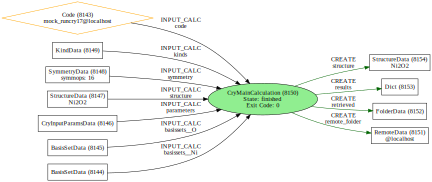

In [8]:
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calc_node)
graph.add_incoming(calc_node, annotate_links="both")
graph.add_outgoing(calc_node, annotate_links="both")
graph.graphviz

In [9]:
calc_node.attributes

{'sealed': True,
 'exit_status': 0,
 'process_state': 'finished',
 'remote_workdir': '/Users/cjs14/GitHub/aiida-crystal17/aiida_crystal17/tests/raw_files/crystal/nio_sto3g_afm_opt',
 'retrieve_temporary_list': [],
 'retrieve_list': ['test.out',
  'main.gui',
  '_scheduler-stdout.txt',
  '_scheduler-stderr.txt'],
 'external_file_name': 'main.gui',
 'parser_name': 'crystal17.main',
 'append_text': '',
 'prepend_text': '',
 'environment_variables': {},
 'import_sys_environment': True,
 'mpirun_extra_params': [],
 'custom_scheduler_commands': '',
 'scheduler_stderr': '_scheduler-stderr.txt',
 'scheduler_stdout': '_scheduler-stdout.txt',
 'output_main_file_name': 'test.out',
 'input_file_name': 'test.d12',
 'withmpi': False,
 'max_wallclock_seconds': 1800,
 'resources': {'num_mpiprocs_per_machine': 1, 'num_machines': 1},
 'process_label': 'CryMainCalculation'}

In [10]:
calc_node.extras

{'immigration_func': 'aiida_crystal17.immigration.create_calcjob',
 'immigrated': True,
 '_aiida_hash': '433913d1f2b53576b7e75a9ed91291d1d6d2e65588c7fb437a917fb271703ed4'}